In [1]:
import subprocess
import os, random, re, json, numbers, sys
sys.path.append("../scripts")
from helper import *
from tqdm import tqdm
from pprint import pprint
import pytz
from datetime import datetime
timezone = pytz.timezone('America/New_York') 
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)


In [2]:
iid_test = [json.loads(l) for l in open("../data/lila/multi/iid/test.json", "r").readlines()]
ood_test = [json.loads(l) for l in open("../data/lila/multi/ood/test.json", "r").readlines()]
tmp = json.load(open("../data/lila/single_number_ans_ids.json", "r"))
iid_selected_ids, ood_selected_ids = tmp['iid_test'], tmp['ood_test']

llm_rel_path = "codegen25-7b-instruct/deffunc"

In [3]:
def EM(pred, gth):
    # check if ratio pred/gth \in [0.999, 1.001]
    # This would give credits to fractions, e.g. 1/7 = 0.1428
    gth = float(gth)
    if gth == 0: return pred == gth
    return np.absolute(pred/gth - 1) <= 0.001

In [4]:
def parse_outputs(outputs):
    ## Postprocess output to extract answer spans
    p = outputs.split("<reponame>")[0]
    return p

def get_program_stdout(outputs, time_limit=10):
    try:
        p = parse_outputs(outputs)
    except: return "PostprocessingError"
    
    ## Execute program with a timer
    try: 
        output = subprocess.run(
            ["python", '-c', p], 
            stdout=subprocess.PIPE, 
            stderr=subprocess.STDOUT, 
            universal_newlines=True,
            timeout=time_limit
        )
        return output.stdout.strip()
    except subprocess.SubprocessError: return "TimeoutError"

In [5]:
output_llm_folder = f"../data/output_decoder_LM/{llm_rel_path}"
output_llm_files = sorted(os.listdir(output_llm_folder))

output_llm_lines = []
for file in output_llm_files[1:]:
    with open(os.path.join(output_llm_folder, file), "r") as f:
        output_llm_lines.extend(f.readlines()[1:])
print(len(output_llm_lines))

5342


In [6]:
# Save execution output to anther file
date = datetime.now(timezone).strftime("%m%d_%H%M%S")
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_{date}.jsonl", "w") as f:
    for l in tqdm(output_llm_lines[:]):
        i, outputs = list(json.loads(l).items())[0]
        f.write(json.dumps({i:get_program_stdout(outputs)})+"\n")


100%|██████████| 5342/5342 [22:19<00:00,  3.99it/s]  


#### Re exec some output programs after installing scipy

In [20]:
exec_ans_d = json.load(open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_exec_ans_types.json", "r"))
ids = exec_ans_d["ModuleNotFoundError"]
print(len(ids))

output_llm_folder = f"../data/output_decoder_LM/{llm_rel_path}"
output_llm_files = sorted(os.listdir(output_llm_folder))

output_llm_lines = []
for file in output_llm_files[:8]:
    with open(os.path.join(output_llm_folder, file), "r") as f:
        output_llm_lines.extend(f.readlines()[1:])
print(len(output_llm_lines))

date = datetime.now(timezone).strftime("%m%d_%H%M%S")
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_{date}.jsonl", "w") as f:
    for l in tqdm(output_llm_lines[:]):
        i, outputs = list(json.loads(l).items())[0]
        if i in ids:
            f.write(json.dumps({i:get_program_stdout(outputs)})+"\n")


42
5342


100%|██████████| 5342/5342 [00:01<00:00, 3620.88it/s] 


In [16]:
## Merge new program outputs with old file
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_0912_163559.jsonl", "r") as f:
    old = {}
    for l in f.readlines():
        d = json.loads(l)
        k = list(d.keys())[0]
        old[k] = d[k]
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_0919_195650_reexec_after_install_scipy.jsonl", "r") as f:
    new = {}
    for l in f.readlines():
        d = json.loads(l)
        k = list(d.keys())[0]
        new[k] = d[k]
print(len(old),len(new))
with open(f"../data/program_eval/{llm_rel_path}/lila_iid_test_single_number_ans_merge_0919_191745_0919_195650.jsonl", "w") as f:
    for i, o in old.items():
        if i in new: outputs = new[i]
        else: outputs = old[i]
        f.write(json.dumps({i:outputs})+"\n")

5342 52


#### Categorize exec outputs

In [6]:
# Eval execution outputs
output_execution_folder = f"../data/program_eval/{llm_rel_path}"
output_execution_files = sorted(os.listdir(output_execution_folder))

output_execution_lines = []
for file in output_execution_files[-1:]:
    print(file)
    with open(os.path.join(output_execution_folder, file), "r") as f:
        output_execution_lines.extend(f.readlines())
print(len(output_execution_lines))

lila_iid_test_single_number_ans_merge_0919_191745_0919_195650.jsonl
5342


In [7]:
# Categorize execution outputs

exec_ans_d = defaultdict(list)
for l in tqdm(output_execution_lines):
    i, o = list(json.loads(l).items())[0]
    
    if "SyntaxError: invalid syntax" in o:
        exec_ans_d['SyntaxError'].append(i)
        continue
    match = re.findall(r'(?P<errortype>[A-Z].*Error)', o)
    if len(match): 
        exec_ans_d[match[-1]].append(i)
        continue
    
    cate, a = find_num_from_str(o)
    exec_ans_d[cate].append((i, a))

print(f"Categorized {sum([len(v) for v in exec_ans_d.values()])} direct answer outputs")
for k, v in exec_ans_d.items():
    print(k, len(v))

100%|██████████| 5342/5342 [00:00<00:00, 149030.38it/s]

Categorized 5342 direct answer outputs
String 1078
SyntaxError 1438
Number 2466
MultiNumbers 130
TypeError 24
NameError 24
TimeoutError 115
RecursionError 14
ValueError 9
MemoryError 22
ZeroDivisionError 17
OverflowError 1
ImportError 2
AttributeError 1
UnboundLocalError 1


In [8]:
## Eval execution outputs that are numbers
exec_ans_em = defaultdict(int)
for i, o in exec_ans_d['Number']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if EM(o, gth):
       exec_ans_em[i] = 1
print(sum(exec_ans_em.values()))
for i, o in exec_ans_d['MultiNumbers']:
    gth = iid_test[int(i)]['Output Answer'][0]
    if any([EM(x, gth) for x in o]):
        exec_ans_em[i] = 1
print(sum(exec_ans_em.values()))
exec_ans_d["EM"] = list(exec_ans_em.keys())

448
471


In [9]:
print("Overall EM = {} / 5342 = {}%".format(len(exec_ans_d["EM"]), len(exec_ans_d["EM"])/53.42))
de = len(exec_ans_d['Number']) + len(exec_ans_d['MultiNumbers'])
print("EM when output is number = {} / {} = {}%".format(len(exec_ans_d["EM"]), de, len(exec_ans_d["EM"])*100/de))

Overall EM = 471 / 5342 = 8.816922500935979%
EM when output is number = 471 / 2596 = 18.143297380585516%


In [19]:
# Save categorized answers 
print(llm_rel_path)
json.dump(exec_ans_d, open(f"../data/lila/results/{llm_rel_path}/iid_test_single_ans_exec_ans_types.json", "w"))


codegen25-7b-instruct/deffunc


1277 471


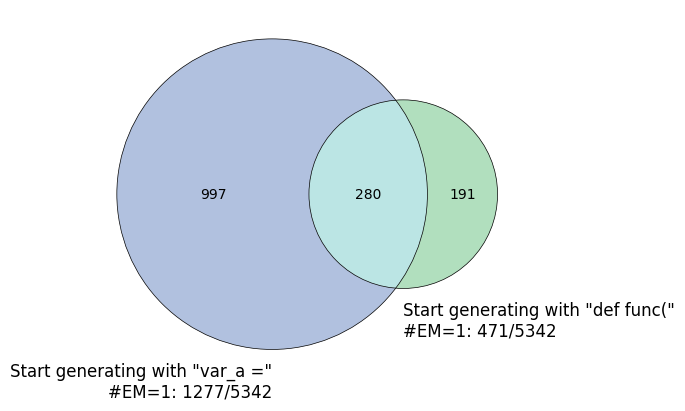

In [15]:
# Do "var_a =" and "def func(" fail on different clusters of examples?
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles

# Examine how often do different generation strategies agree
var_a_em_ids = json.load(open("../data/lila/results/codegen25-7b-instruct/var_a/iid_test_single_ans_exec_ans_types.json", "r"))["EM"]
deffunc_em_ids = json.load(open("../data/lila/results/codegen25-7b-instruct/deffunc/iid_test_single_ans_exec_ans_types.json", "r"))["EM"]
print(len(var_a_em_ids), len(deffunc_em_ids))
venn2(
    [set(var_a_em_ids), set(deffunc_em_ids)],
    set_colors=('#3E64AF', '#3EAF5D'),#, '#E6E600'), 
    set_labels = (
        f'Start generating with "var_a ="\n#EM=1: {len(var_a_em_ids)}/5342',
        f'Start generating with "def func("\n#EM=1: {len(deffunc_em_ids)}/5342',
    )
)
venn2_circles([set(var_a_em_ids), set(deffunc_em_ids)], lw=0.5)

plt.show()

In [16]:
# save post-processed results to csv
import csv
var_a_ans_d = json.load(open("../data/lila/results/codegen25-7b-instruct/var_a/iid_test_single_ans_exec_ans_types.json", "r"))
deffunc_ans_d = json.load(open("../data/lila/results/codegen25-7b-instruct/deffunc/iid_test_single_ans_exec_ans_types.json", "r"))

rows = {}
for var_a_ans_cate, ids in var_a_ans_d.items():
    if var_a_ans_cate == "EM": continue
    for x in ids:
        if isinstance(x, (tuple, list)):
            i, dir_ans = x
            gth = float(iid_test[int(i)]['Output Answer'][0])
            rows[i] = [i, gth, dir_ans, int(i in var_a_ans_d["EM"])]
        else:
            gth = float(iid_test[int(x)]['Output Answer'][0])
            rows[x] = [x, gth, var_a_ans_cate, 0]
for deffunc_ans_cate, ids in deffunc_ans_d.items():
    if deffunc_ans_cate == "EM": continue
    for x in ids:
        if isinstance(x, (tuple, list)):
            i, exec_ans = x
            rows[i].extend([exec_ans, int(i in deffunc_ans_d["EM"])])
        else:
            rows[x].extend([deffunc_ans_cate, 0])

rows = [x[1] for x in sorted(rows.items(), key=lambda x: int(x[0]))]
print(len(rows))

with open("../data/lila/results/iid_test_single_ans.csv", "w") as f:
    w = csv.writer(f, delimiter= ',')
    w.writerow(["id", "gth_ans", "exec_ans_var_a", "em_var_a", "exec_ans_deffunc", "em_deffunc"])
    for r in rows: w.writerow(r)


5342


In [18]:
results = pd.read_csv(
    f"../data/lila/results/{llm_rel_path}/iid_test_single_ans.csv", 
    header=0, 
    keep_default_na=False,
)
print(len(results))
results.head(30)

5342


,id,gth_ans,exec_ans_var_a,em_var_a,exec_ans_deffunc,em_deffunc
0,0,370.0000,,0,,0
1,1,-5.0000,,0,SyntaxError,0
2,2,0.0045,,0,SyntaxError,0
3,3,0.0000,-16,0,,0
4,4,1.0200,1.02,1,1.02,1
5,5,-6.0000,,0,0.6666666666666666,0
6,6,0.5000,0,0,0,0
7,7,5.0000,-0.3999999999999986,0,,0
8,8,0.2000,13,0,-534,0
9,9,1.5800,,0,1.58,1


### Cluster failures according to some measure of difficulty

In [4]:
# Treat number_count as a measure of difficulty
iid_test = [json.loads(l) for l in open("../data/lila/multi/iid/test.json", "r").readlines()]
tmp = json.load(open("../data/lila/single_number_ans_ids.json", "r"))
iid_selected_ids = tmp['iid_test']

number_counts = {}
for i in tqdm(iid_selected_ids):
    number_counts[i] = len(count_numbers_in_str(iid_test[i]['Input']))

100%|██████████| 5342/5342 [00:00<00:00, 83113.75it/s]


In [7]:
lengths = [len(iid_test[i]['Input'].strip()) for i in iid_selected_ids]
np.mean(lengths), np.std(lengths)

(162.90228378884314, 90.85821419393105)

In [8]:
Counter([l//30 for l in lengths])

Counter({2: 436,
         3: 841,
         1: 491,
         5: 761,
         0: 88,
         4: 884,
         7: 398,
         6: 552,
         11: 102,
         8: 280,
         9: 197,
         10: 128,
         12: 48,
         14: 30,
         13: 41,
         16: 12,
         17: 16,
         15: 22,
         20: 3,
         18: 7,
         19: 2,
         28: 1,
         23: 2})